## Modeling of bank failures by FDIC 

## Logistic Regression with Tensorflow

In [55]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import tensorflow as tf

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

In [56]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [57]:
df_train = pd.read_hdf('data/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('data/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('data/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('readonly/df_FDIC_learn.h5',key='df')
print(df_closure_learn.index.names)

['IDRSSD', 'date']


In [58]:
# look at train dataframe table
df_train

,,Financial Institution Name,Institution Name,total_assets,defaulter,Failure / Assistance,log_TA,NI_to_TA,Equity_to_TA,NPL_to_TL,REO_to_TA,...,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,default_within_1Y,Failure,max_total_assets,num_records,non_defaulter,const
IDRSSD,date,,,,,,,,,,,,,,,,,,,,,
904957,2008-03-31,COLORADO NATIONAL BANK,COLORADO NATIONAL BANK,1.421380e+05,1.0,FAILURE,-0.048734,-6.505183,-0.759562,0.880756,-0.162301,...,0.004823,-0.367905,-0.840312,-0.582232,1.0,1.0,1.421380e+05,31.0,0.0,1
202907,2011-06-30,"COMMUNITY BANK, NATIONAL ASSOCIATION",NaN,6.364903e+06,0.0,NaN,2.754852,0.143005,0.249275,-0.405931,-0.327268,...,-0.003057,0.205816,-0.140365,0.003962,0.0,NaN,8.494486e+06,60.0,1.0,1
652874,2012-12-31,"NEXBANK, SSB",NaN,7.847810e+05,0.0,NaN,1.211269,0.229021,-0.301031,-0.750449,-0.304600,...,-0.003506,0.470935,-0.799310,0.284815,0.0,NaN,2.698563e+06,60.0,1.0,1
9115,2003-03-31,COMMERCE BANK/SHORE NATIONAL ASSOCIATION,NaN,2.173481e+06,0.0,NaN,1.962490,0.253469,-0.922810,-0.752942,-0.374868,...,-0.002819,0.225454,-0.324276,1.091618,0.0,NaN,2.697759e+06,12.0,1.0,1
3344611,2012-06-30,"BANK OF AMERICA RHODE ISLAND, NATIONAL ASSOCIA...",NaN,1.940546e+07,1.0,NaN,3.576923,0.103615,0.088508,2.380231,-0.121243,...,0.001903,0.101099,-0.791229,-0.408817,0.0,NaN,3.921104e+07,31.0,0.0,1
2560526,2009-03-31,CENTENNIAL BANK,CENTENNIAL BANK,2.414400e+05,1.0,FAILURE,0.341981,-1.857315,-0.643992,4.583630,10.678175,...,-0.004326,-0.945865,-1.657427,-0.679579,1.0,1.0,2.414400e+05,35.0,0.0,1
12311,2002-12-31,"HUNTINGTON NATIONAL BANK, THE",NaN,2.739928e+07,0.0,NaN,3.831313,0.017434,-1.027312,-0.217300,-0.345599,...,-0.000178,0.196792,-0.589442,-0.048953,0.0,NaN,7.087978e+07,60.0,1.0,1
2714570,2009-06-30,SUN WEST BANK,SUN WEST BANK,4.081850e+05,1.0,FAILURE,0.729213,-4.605855,-0.730066,3.972000,0.165297,...,0.083667,-5.016063,-0.231379,-0.822222,1.0,1.0,4.558640e+05,36.0,0.0,1
1001152,2008-03-31,INTERNATIONAL BANK OF COMMERCE,NaN,9.359919e+06,0.0,NaN,3.039238,0.166162,-0.165557,-0.196155,-0.361847,...,-0.002651,0.187922,-0.467883,-0.214504,0.0,NaN,1.063811e+07,60.0,1.0,1


In [59]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [60]:
print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 331


In [61]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [62]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [12]:
# define the model
reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)

# build Logistic Regression model using Tensorflow
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, dtype=tf.float32, name="w")

# Construct model
logits = tf.matmul(X, theta)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))
#loss = -tf.reduce_mean(tf.reduce_sum(y * tf.log(tf.sigmoid(logits)) + (1 - y) * tf.log(1 - tf.sigmoid(logits))))

# Test model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

### Train Logistic Regression TF model

- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [13]:
n_epochs = 1001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

display_step = 100

with tf.Session() as sess:
    
    # run the initializer
    sess.run(init)
    
    # train for n_epochs
    for epoch in range(n_epochs): # train the model n_epochs times
        avg_cost = 0.
        
        for i in range(n_batches):
            X_batch, y_batch = random_batch(X_train=X_trainTf, y_train=y_trainTf, batch_size=batch_size)
            
            _, c = sess.run([optimizer, loss], feed_dict={X: X_batch, y: y_batch})
            
            # Compute average loss
            avg_cost += c / n_batches
            
        #predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y_testTf, 1))
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            print("Accuracy:", accuracy.eval({X: X_testTf, y: y_testTf}))


Epoch: 0100 cost= 0.176481017
Accuracy: 1.0
Epoch: 0200 cost= 0.183351975
Accuracy: 1.0
Epoch: 0300 cost= 0.118329323
Accuracy: 1.0
Epoch: 0400 cost= 0.199669106
Accuracy: 1.0
Epoch: 0500 cost= 0.148497466
Accuracy: 1.0
Epoch: 0600 cost= 0.127017917
Accuracy: 1.0
Epoch: 0700 cost= 0.167575077
Accuracy: 1.0
Epoch: 0800 cost= 0.161472603
Accuracy: 1.0
Epoch: 0900 cost= 0.163393621
Accuracy: 1.0
Epoch: 1000 cost= 0.151921238
Accuracy: 1.0


In [ ]:
# predictions
threshold = 0.5
y_pred = (y_proba_val >= threshold)
print(np.sum(y_pred))

In [ ]:
### GRADED PART (DO NOT EDIT) ###
y_pred.squeeze()
### GRADED PART (DO NOT EDIT) ###

In [ ]:
# evaluate precision, recall, and AUC
auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape == y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    try:
        plt.title('ROC_curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except:
        pass

In [ ]:
### GRADED PART (DO NOT EDIT) ###
[precision, recall, roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

## Neural Network with Tensorflow

In [63]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [64]:
X_trainTf.shape

(641, 19)

In [65]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        W_init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(W_init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

### Construct Neural Network

Neural Network with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
Use neuron_layer() function to construct neural network layers.

- Use ReLU activation function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Use sparse softmax cross-entropy with logits as a loss function

In [113]:
n_hidden1 = 200
n_hidden2 = 100
n_outputs = 2 # binary classification (defaulted, not defaulted bank)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def predict(input_layer):
    hidden1 = neuron_layer(X=input_layer, n_neurons=n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(X=hidden1, n_neurons=n_hidden2, name="hidden2", activation=tf.nn.relu)
    output = neuron_layer(X=hidden2, n_neurons=n_outputs, name="output", activation=None)
    return output

output = predict(X)

# loss function and optimizer
loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=output, labels=y))
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

### Train Neural Network

**Instructions**
Train neural network passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, evaluate accuracy using **X_testTf**, **y_testTf**

In [114]:
learning_rate = 0.05
n_epochs = 1000
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

display_step = 100

with tf.Session() as sess:
    
    # run the initializer
    sess.run(init)
    
    # train for n_epochs
    for epoch in range(n_epochs): # train the model n_epochs times
        avg_cost = 0.
        
        for i in range(n_batches):
            X_batch, y_batch = random_batch(X_train=X_trainTf, y_train=y_trainTf, batch_size=batch_size)
            
            _, c = sess.run([optimizer, loss], feed_dict={X: X_batch, y: y_batch})
            
            # Compute average loss
            avg_cost += c / n_batches
            
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    
    # prediction accuracy
    threshold = 0.5
    binary_output = sess.run(tf.nn.softmax(output), feed_dict={X: X_testTf})
    y_proba_val = binary_output[:,1]
    y_pred = (y_proba_val >= threshold)
    correct_prediction = tf.equal(y_pred, tf.cast(y, tf.bool))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({y: y_testTf})) 

Epoch: 0100 cost= 0.176662476
Epoch: 0200 cost= 0.125363574
Epoch: 0300 cost= 0.064465305
Epoch: 0400 cost= 0.062048554
Epoch: 0500 cost= 0.035743782
Epoch: 0600 cost= 0.026675599
Epoch: 0700 cost= 0.028302619
Epoch: 0800 cost= 0.016031464
Epoch: 0900 cost= 0.012937397
Epoch: 1000 cost= 0.009422912
Accuracy: 0.978852


precision:  0.9873417721518988
recall:  0.968944099378882
AUC score =  0.9876141761052246
roc_auc =  0.9876141761052246
KS_test =  0.9633905736207526


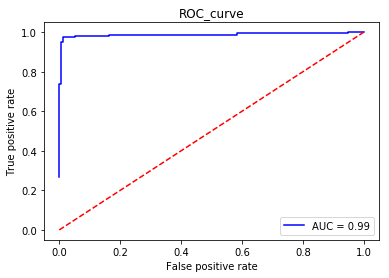

In [115]:
# evaluate precision, recall, and AUC
auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape == y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    try:
        plt.title('ROC_curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except:
        pass